<a href="https://colab.research.google.com/github/mzouros/dl_gmsa/blob/main/Greek_Music_Sentiment_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Run Colab localy

jupyter notebook \
--NotebookApp.allow_origin='https://colab.research.google.com' \
--port=8888 \
--NotebookApp.port_retries=0

In [25]:
# Imports

import os
import glob
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# .mp3 to .wav conversion
from pydub import AudioSegment

%matplotlib inline

In [ ]:
# Dataset size

mp3Path = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/MP3'
mp3Count = 0
wmaCount = 0
flacCount = 0
datasetAlbumNames = [] 
datasetTrackNames = []
data = []
dataset = []

for folder in os.listdir(mp3Path):
  trackCount = 0
  datasetAlbumNames.append(folder)
  songPath = mp3Path + '/' + folder
  for song in os.listdir(songPath):
    if song.lower().endswith(".mp3".lower()):
      # print(os.path.join(songPath, song))
      mp3Count += 1
    # for .wma  
    else:
      # print(os.path.join(songPath, song))
      wmaCount += 1
    datasetTrackNames.append(os.path.splitext(song)[0])
    trackCount += 1
  print(folder, trackCount)
  data = [folder, trackCount]
  dataset.append(data)
print("")
print("Total songs found:", mp3Count+wmaCount+flacCount)

# Export to .csv
dataset.sort()
df = pd.DataFrame(dataset, columns = ['artist_name', 'number_of_songs'])
df.to_csv("Final_Dataset.csv", sep = ',')

In [ ]:
# Spotify Developer Credentials

client_id = 'f1947444cbe9421e815b74a771326877'
client_secret = 'a1099b60916440aabc9a24f1583bb73e'

client_credentials_manager = SpotifyClientCredentials(client_id, client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [ ]:
# Get the IDs for each playlist of the user

userId = 'mdkyyoecyz3a2cxye8qjvt91l'
playlistIds = []
playlistNames = [] 
offset = 0

userPlaylists1 = sp.user_playlists(userId, offset=0) # 0 - 49
userPlaylists2 = sp.user_playlists(userId, offset=50) # 50 - 99
userPlaylists3 = sp.user_playlists(userId, offset=100) # 100 - 102
for item in userPlaylists1['items']:
  playlistIds.append(item['id'])
  playlistNames.append(item['name'])
for item in userPlaylists2['items']:
  playlistIds.append(item['id'])
  playlistNames.append(item['name'])
for item in userPlaylists3['items']:
  playlistIds.append(item['id'])
  playlistNames.append(item['name'])
print("Playlists' ids:", playlistIds)
print("Playlists' names:", playlistNames)
print("No of Playlists:", len(playlistNames))

In [ ]:
# Validate Spotify's playlists' names against dataset's albums' names
# If it prints nothing, we are good to go

datasetAlbumNames.sort()
playlistNames.sort()

for i in range(102):
  if playlistNames[i] != datasetAlbumNames[i]:
    print("Names [", playlistNames[i], "] and [", datasetAlbumNames[i], "] are not identical. Found on index:", i)

In [ ]:
# Get the IDs for each track of each playlist of the user

user = 'mzouros'
spotifyTrackIds = []
spotifyTrackNames = []

for id in playlistIds:
  # Check size of the playlist
  if sp.user_playlist_tracks(user, id)['total'] < 100:  
    playlist = sp.user_playlist_tracks(user, id)
    for item in playlist['items']:
      track = item['track']
      print(track['artists'][0]['name'], "---", track['name'], "-", track['id'])
      spotifyTrackIds.append(track['id'])
      spotifyTrackNames.append(track['name'])
  elif sp.user_playlist_tracks(user, id)['total'] < 200:
    offset = 0
    for x in range(2):
      playlist = sp.user_playlist_tracks(user, id, offset = offset)
      for item in playlist['items']:
        track = item['track']
        print(track['artists'][0]['name'], "---", track['name'], "-", track['id'])
        spotifyTrackIds.append(track['id'])
        spotifyTrackNames.append(track['name'])
      offset += 100
  else:
    offset = 0
    for x in range(3):
      playlist = sp.user_playlist_tracks(user, id, offset = offset)
      for item in playlist['items']:
        track = item['track']
        print(track['artists'][0]['name'], "---", track['name'], "-", track['id'])
        spotifyTrackIds.append(track['id'])
        spotifyTrackNames.append(track['name'])
      offset += 100

print(len(spotifyTrackIds))

In [ ]:
# Validate Spotify's playlists' tracks' names against dataset's albums' tracks' names
# If it prints zero, we are good to go

missedCount = 0
for track in datasetTrackNames: 
  track = track.replace("_", "/") # song titles with "slashes" on Spotify are saved with "underscore" in our dataset
  if track not in spotifyTrackNames:
    missedCount += 1
    print(track)
print(missedCount)

In [ ]:
# Get Tracks Information and dump them to .csv

tracks = []
for id in spotifyTrackIds:
  try:
    meta = sp.track(id)
    features = sp.audio_features(id)

    # meta
    name = meta['name']
    album = meta['album']['name']
    artist = meta['album']['artists'][0]['name']
    release_date = meta['album']['release_date']
    length = meta['duration_ms']
    popularity = meta['popularity']

    # features
    acousticness = features[0]['acousticness']
    danceability = features[0]['danceability']
    energy = features[0]['energy']
    valence = features[0]['valence']
    instrumentalness = features[0]['instrumentalness']
    liveness = features[0]['liveness']
    loudness = features[0]['loudness']
    speechiness = features[0]['speechiness']
    tempo = features[0]['tempo']
    time_signature = features[0]['time_signature']

    track = [name, album, artist, release_date, length, popularity, danceability, acousticness, energy, valence, instrumentalness, liveness, loudness, speechiness, tempo, time_signature]
    print(track)
    tracks.append(track)
  # We ensure that a faulty id or an empty JSON, won't crash the run  
  except ValueError:
    try:
      print("JSONDecodeError")
    except NameError:
      print("NameError")

# Create metadata/features .csv
df = pd.DataFrame(tracks, columns = ['name', 'album', 'artist', 'release_date', 'length', 'popularity', 'danceability', 'acousticness', 'energy', 'valence', 'instrumentalness', 'liveness', 'loudness', 'speechiness', 'tempo', 'time_signature'])
df.to_csv("Spotify_Tracks.csv", sep = ',')

In [ ]:
# .mp3 to .wav and export

wavPath = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/WAV/'

for folder in os.listdir(mp3Path):
  songPath = mp3Path + '/' + folder
  os.mkdir(wavPath+folder)
  for song in os.listdir(songPath):
    sound = AudioSegment.from_mp3(songPath+'/'+song)
    sound.export(wavPath+folder+'/'+os.path.splitext(song)[0]+'.wav', format="wav")

***We classify each song of our dataset to an emotion, according to the Valence-Arousal dimensional model***

![](https://drive.google.com/uc?export=view&id=1zZapbxBgMSLfRKnqhn6qkR40ZBT2q3Pp)

In [26]:
# Read Energy (Arousal) and Valence features from .csv and classify each song of the dataset according to the Valence-Arousal dimensional model

spotify_tracks = '/home/mike/Artificial Intelligence MSc/2nd Semester/4. Deep Learning/Giannakopoulos/Exercises/Spotify_Tracks.csv'

energyValenceValues = []
artistTrackNames = []
sentiments = []

import csv
with open(spotify_tracks) as csv_file:
  csv_reader = csv.reader(csv_file, delimiter=',')
  line_count = 0
  for row in csv_reader:
    if line_count == 0:
      print ('  Energy  Valence')
      line_count = 1
    else:
      energyValenceValues.append([float(row[9]), float(row[10])])
      artistTrackNames.append([row[3], row[1]])
energyValenceValues = np.array(energyValenceValues)
artistTrackNames = np.array(artistTrackNames)

excitedCount = 0
happyCount = 0
contentCount = 0
calmCount = 0
depressedCount = 0
sadCount = 0
afraidCount = 0
angryCount = 0

for x in energyValenceValues:
  if x[0] >= 0.5 and x[1] >= 0.5 and x[0] >= x[1]:
    sentiments.append('Excited')
    excitedCount += 1
  elif x[0] >= 0.5 and x[1] >= 0.5 and x[0] <= x[1]:
    sentiments.append('Happy')
    happyCount += 1
  elif x[0] <= 0.5 and x[1] >= 0.5 and x[1] - (1 - x[0]) >= 0:
    sentiments.append('Content')
    contentCount += 1
  elif x[0] <= 0.5 and x[1] >= 0.5 and x[1] - (1 - x[0]) <= 0:
    sentiments.append('Calm')
    calmCount += 1
  elif x[0] <= 0.5 and x[1] <= 0.5 and x[0] >= x[1]:
    sentiments.append('Sad')
    depressedCount += 1
  elif x[0] <= 0.5 and x[1] <= 0.5 and x[0] <= x[1]:
    sentiments.append('Depressed')
    sadCount += 1
  elif x[0] >= 0.5 and x[1] <= 0.5 and x[0] - (1 - x[1]) <= 0:
    sentiments.append('Afraid')
    afraidCount += 1
  else:
    sentiments.append('Angry')
    angryCount += 1

sentiments = np.array(sentiments)

print(energyValenceValues)
print('')
print(sentiments)

  Energy  Valence
[[0.315  0.308 ]
 [0.844  0.968 ]
 [0.516  0.28  ]
 ...
 [0.707  0.132 ]
 [0.192  0.0519]
 [0.312  0.0808]]

['Sad' 'Happy' 'Afraid' ... 'Afraid' 'Sad' 'Sad']


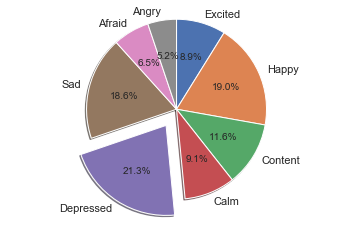


Excited: 463
Happy: 991
Content: 605
Calm: 476
Depressed: 1113
Sad: 970
Afraid: 341
Angry: 270


In [31]:
counts = np.array([excitedCount, happyCount, contentCount, calmCount, depressedCount, sadCount, afraidCount, angryCount])
labels = ["Excited", "Happy", "Content", "Calm", "Depressed", "Sad", "Afraid", "Angry"]
explode = (0, 0, 0, 0, 0.3, 0, 0, 0)

fig1, ax1 = plt.subplots()
ax1.pie(counts, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90, radius=1.4, counterclock=False)
ax1.axis('equal')
plt.show() 

print('')
print('Excited:', excitedCount)
print('Happy:', happyCount)
print('Content:', contentCount)
print('Calm:', calmCount)
print('Depressed:', depressedCount)
print('Sad:', sadCount)
print('Afraid:', afraidCount)
print('Angry:', angryCount)